## ResNet (DNN) Example for Fashion MNIST Dataset

2025-06-09 18:45:12.377761: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 18:45:12.758989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749494712.875528  210811 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749494712.906014  210811 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749494713.196641  210811 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

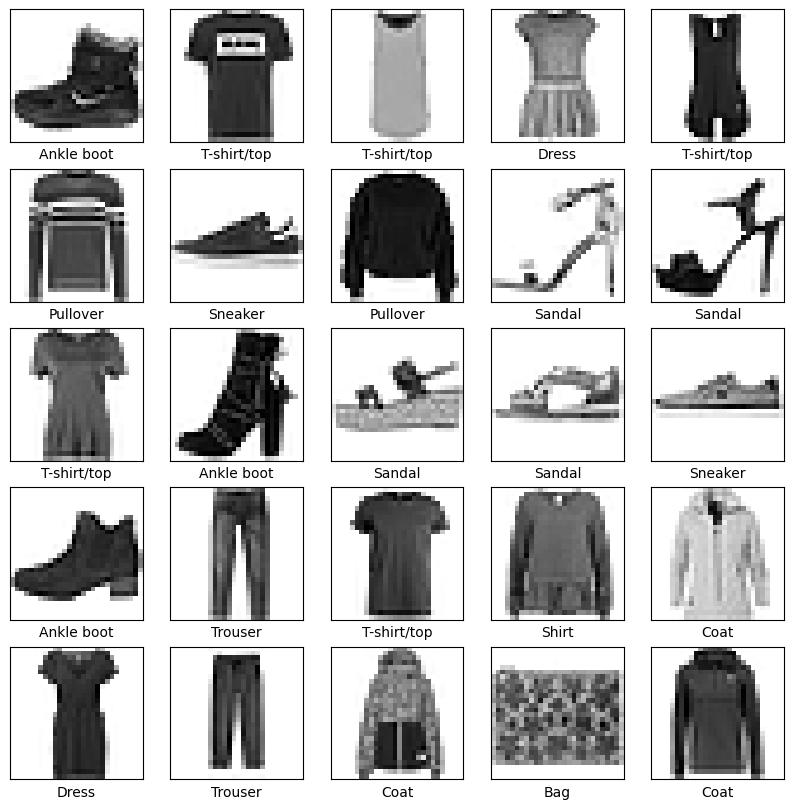

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.layers import (
    Dense,
    Input,
    Add,
    Activation,
    BatchNormalization,
    Dropout,
)
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD
from keras import regularizers

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Flatten the images for DNN
x_train_flat = x_train.reshape(-1, 28 * 28)
x_test_flat = x_test.reshape(-1, 28 * 28)

# Visualize some samples
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(y_train[i])])
plt.show()

In [ ]:
# 2 layers per residual block
def residual_block(x, units):
    shortcut = x
    if x.shape[-1] != units:
        shortcut = Dense(units, kernel_regularizer=regularizers.l2(0.001))(shortcut)

    x = Dense(units, kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.8)(x) 

    x = Dense(units, kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

# 11 layers total
def create_resnet_dnn():
    inputs = Input(shape=(784,))

    x = BatchNormalization()(inputs)

    x = Dense(1024, kernel_regularizer=regularizers.l2(0.001))(x) 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = residual_block(x, 512)

    x = Dense(256, kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    x = residual_block(x, 256)

    x = Dense(128, kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = residual_block(x, 128)
    x = Dropout(0.4)(x)
    
    outputs = Dense(10, activation="softmax")(x)

    return Model(inputs, outputs)


resnet_model = create_resnet_dnn()

In [19]:
resnet_model = create_resnet_dnn()
resnet_model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [20]:
resnet_history = resnet_model.fit(
    x_train_flat,
    y_train,
    validation_split=0.15,
    batch_size=128,
    epochs=40,
    callbacks=[
        EarlyStopping(
            patience=15,
            restore_best_weights=True,
            monitor="val_accuracy",
            min_delta=0.001,
        ),
        ReduceLROnPlateau(
            patience=5, factor=0.5, min_lr=1e-6, monitor="val_accuracy", verbose=1
        ),
    ],
    verbose=1,
)

Epoch 1/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.3330 - loss: 6.0826 - val_accuracy: 0.6847 - val_loss: 4.3164 - learning_rate: 0.0100
Epoch 2/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6893 - loss: 4.2212 - val_accuracy: 0.7869 - val_loss: 3.6119 - learning_rate: 0.0100
Epoch 3/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7742 - loss: 3.5553 - val_accuracy: 0.8322 - val_loss: 3.0801 - learning_rate: 0.0100
Epoch 4/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8188 - loss: 3.0412 - val_accuracy: 0.8596 - val_loss: 2.6387 - learning_rate: 0.0100
Epoch 5/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8439 - loss: 2.6209 - val_accuracy: 0.8662 - val_loss: 2.3101 - learning_rate: 0.0100
Epoch 6/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8559 - loss: 2.2807 - val_accuracy: 0.8720 - val_loss: 2.0162 - learning_rate: 0.0100
Epoch 7/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8637 - loss: 1.9963 

In [ ]:
# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()

    plt.show()

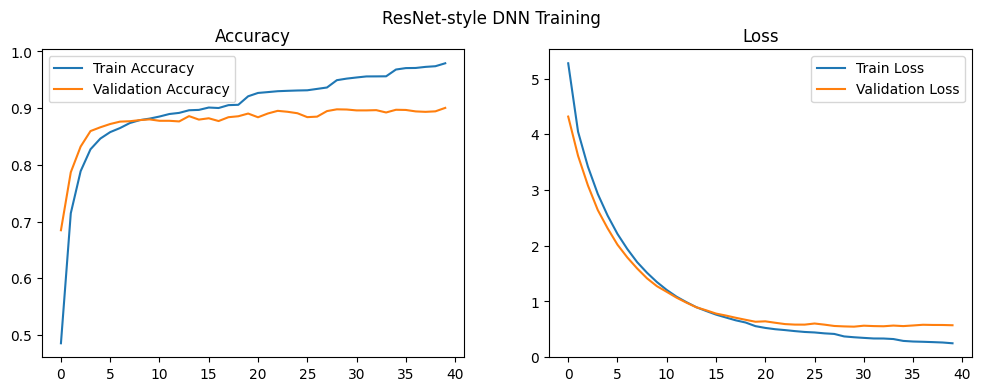

In [22]:
plot_history(resnet_history, "ResNet-style DNN Training")

In [23]:
# Evaluate on test set
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(
    x_test_flat, y_test, verbose=0
)

In [24]:
print(f"ResNet-style DNN Test Accuracy: {resnet_test_acc:.4f}")

ResNet-style DNN Test Accuracy: 0.9005



ResNet-style DNN Predictions:
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


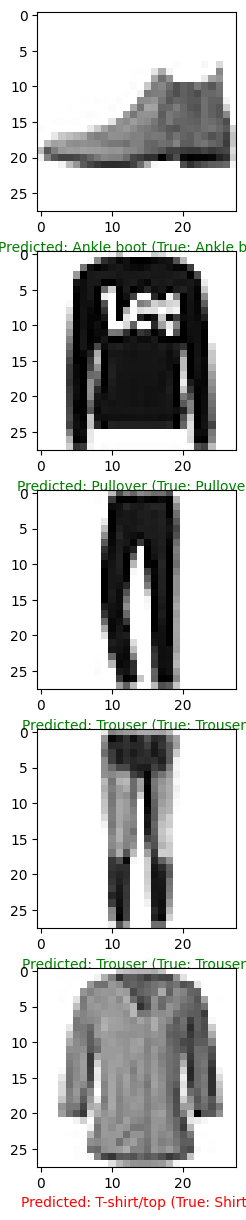

In [25]:
# Make predictions and visualize some results
def plot_predictions(model, x_test, y_test, num_images=5):
    predictions = model.predict(x_test)
    plt.figure(figsize=(15, 3 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.binary)
        pred_label = np.argmax(predictions[i])
        true_label = np.argmax(y_test[i])
        color = "green" if pred_label == true_label else "red"
        plt.xlabel(
            f"Predicted: {class_names[pred_label]} (True: {class_names[true_label]})",
            color=color,
        )
    plt.show()


print("\nResNet-style DNN Predictions:")
plot_predictions(resnet_model, x_test_flat, y_test)

# **Performance Analysis Table**

| Metric                       | Value      |
| ---------------------------- | ---------- |
| **Best Train Accuracy**      | \~0.98     |
| **Best Validation Accuracy** | \~0.90     |
| **Final Test Accuracy**      | **0.9005** |
| **Initial Train Loss**       | \~5.3      |
| **Final Train Loss**         | \~0.25     |
| **Final Validation Loss**    | \~0.55     |
| **Training Epochs**          | 40         |
| **Overfitting**              | Mild       |


**Training Setup**
------------------

| Component | Configuration |
| --- | --- |
| **Input Shape** | (784,)  |
| **Optimizer** | Gradient Descent with Momentum |
| **Loss Function** | Categorical Crossentropy |
| **Epochs** | 40 |
| **Dropout Rates** | 0.8, 0.7 inside residuals; 0.5 and 0.4 outside |
| **Regularization** | L2 (λ = 0.001) on all Dense layers |
| **Activation Function** | ReLU (internal) and Softmax (output layer) |
| **Batch Normalization** | After every Dense layer |
| **Output Layer** | Dense (10, softmax) |

#### Block Order (11 Layers [2 per residual block])

Input (784) → BatchNorm

→ Dense (1024) → Batch Normalization → ReLU

→ ResidualBlock(512)

→ Dense (256) → Batch Normalization → ReLU → Dropout (0.5)

→ ResidualBlock (256)

→ Dense (128) → Batch Normalization → ReLU

→ ResidualBlock (128)

→ Dropout (0.4)

→ Output: Dense (10, softmax)


#### Residual Block Structure

Input

→ Dense (units)

→ Batch Normalization

→ ReLU

→ Dropout (0.8)

→ Dense (units)

→ Batch Normalization

→ Dropout (0.7)

→ Add

→ ReLU

# **Model Performance Summary**

1.  **Strong Learning Curve**:

    -   The model achieves over **85% accuracy** within the first 10 epochs.

    -   Training accuracy approaches **98%**.

2.  **Moderate Generalization Gap**:

    -   Validation accuracy saturates around **90%** from epoch ~15.

    -   This plateau alongside increasing training accuracy indicates **slight overfitting**.

3.  **Effective Loss Reduction**:

    -   Training loss drops steadily from **5.3 to 0.25**.

    -   Validation loss follows closely but begins to plateau around **epoch 25**, ending near **0.55**.

4.  **Final Test Accuracy**:

    -   A strong result of **90.05%** on test data confirms that the ResNet-style DNN generalizes well.